In [1]:
import torch
import pandas as pd
import numpy as np

from ltn_imp.automation.knowledge_base import KnowledgeBase
from ltn_imp.automation.data_loaders import LoaderWrapper

## Data Preparation

In [2]:
!poetry run poe download-datasets

Poe => mkdir -p examples/datasets
Poe => curl -L -o examples/datasets/iris_training.csv https://raw.githubusercontent.com/tommasocarraro/LTNtorch/main/examples/datasets/iris_training.csv
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2218  100  2218    0     0   4061      0 --:--:-- --:--:-- --:--:--  4054
Poe => curl -L -o examples/datasets/iris_test.csv https://raw.githubusercontent.com/tommasocarraro/LTNtorch/main/examples/datasets/iris_test.csv
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   598  100   598    0     0   1159      0 --:--:-- --:--:-- --:--:--  1161
Poe => curl -L -o examples/datasets/real_estate.csv https://raw.githubusercontent.com/tommasocarraro/LTNtorch/main/examples/datasets/real-estate.csv
  % Total    % Received % Xferd  Average Spee

In [3]:
train_data = pd.read_csv("datasets/iris_training.csv")
test_data = pd.read_csv("datasets/iris_test.csv")

train_labels = train_data.pop("species")
test_labels = test_data.pop("species")

train_data = torch.tensor(train_data.to_numpy()).float()
test_data = torch.tensor(test_data.to_numpy()).float()

train_labels = torch.tensor(train_labels.to_numpy()).float()
test_labels = torch.tensor(test_labels.to_numpy()).float()

In [4]:
pd.DataFrame(train_labels)

,0
0,2.0
1,1.0
2,2.0
3,0.0
4,0.0
...,...
115,1.0
116,1.0
117,0.0
118,0.0


In [5]:
# we define predicate P
class MLP(torch.nn.Module):
    """
    This model returns the logits for the classes given an input example. It does not compute the softmax, so the output
    are not normalized.
    This is done to separate the accuracy computation from the satisfaction level computation. Go through the example
    to understand it.
    """
    def __init__(self, layer_sizes=(4, 16, 16, 8, 3)):
        super(MLP, self).__init__()
        self.elu = torch.nn.ELU()
        self.dropout = torch.nn.Dropout(0.2)
        self.linear_layers = torch.nn.ModuleList([torch.nn.Linear(layer_sizes[i - 1], layer_sizes[i])
                                                  for i in range(1, len(layer_sizes))])

    def forward(self, x, training=False):
        """
        Method which defines the forward phase of the neural network for our multi class classification task.
        In particular, it returns the logits for the classes given an input example.

        :param x: the features of the example
        :param training: whether the network is in training mode (dropout applied) or validation mode (dropout not applied)
        :return: logits for example x
        """
        for layer in self.linear_layers[:-1]:
            x = self.elu(layer(x))
            if training:
                x = self.dropout(x)
        logits = self.linear_layers[-1](x)
        return logits


class LogitsToPredicate(torch.nn.Module):
    """
    This model has inside a logits model, that is a model which compute logits for the classes given an input example x.
    The idea of this model is to keep logits and probabilities separated. The logits model returns the logits for an example,
    while this model returns the probabilities given the logits model.

    In particular, it takes as input an example x and a class label l. It applies the logits model to x to get the logits.
    Then, it applies a softmax function to get the probabilities per classes. Finally, it returns only the probability related
    to the given class l.
    """
    def __init__(self, logits_model):
        super(LogitsToPredicate, self).__init__()
        self.logits_model = logits_model
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x, l, training=True):
        logits = self.logits_model(x, training=training)
        probs = self.softmax(logits)
        out = torch.sum(probs * l, dim=1)
        return out

In [6]:
class DataLoader(object):
    def __init__(self,
                 data,
                 labels,
                 batch_size=1,
                 shuffle=True):
        self.data = data
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle

    def __len__(self):
        return int(np.ceil(self.data.shape[0] / self.batch_size))

    def __iter__(self):
        n = self.data.shape[0]
        idxlist = list(range(n))
        if self.shuffle:
            np.random.shuffle(idxlist)

        for _, start_idx in enumerate(range(0, n, self.batch_size)):
            end_idx = min(start_idx + self.batch_size, n)
            data = self.data[idxlist[start_idx:end_idx]]
            labels = self.labels[idxlist[start_idx:end_idx]]

            yield data, labels

# create train and test loader
train_loader = DataLoader(train_data, train_labels, 64, shuffle=True)
test_loader = DataLoader(test_data, test_labels, 64, shuffle=False)

In [7]:
def compute_accuracy(loader, model, num_classes):
    class_correct = np.zeros(num_classes)
    class_total = np.zeros(num_classes)

    for data, labels in loader:
        predictions = model(data).detach().numpy()
        predictions = np.argmax(predictions, axis=1)
        labels = labels.numpy()  # Convert labels to numpy array

        for i in range(num_classes):
            class_mask = (labels == i)
            class_correct[i] += np.sum(predictions[class_mask] == labels[class_mask])
            class_total[i] += np.sum(class_mask)

    class_accuracy = class_correct / class_total

    # Print accuracy for each class
    for i in range(num_classes):
        print(f'Accuracy for class {i}: {class_accuracy[i]:.2f}')

    # Compute and print general accuracy
    overall_accuracy = np.sum(class_correct) / np.sum(class_total)
    print(f'Overall accuracy: {overall_accuracy:.2f}')

## My Implementation

In [8]:
mlp = MLP()
model = LogitsToPredicate(mlp)

In [9]:
compute_accuracy(train_loader, model = mlp, num_classes=3)

Accuracy for class 0: 1.00
Accuracy for class 1: 0.00
Accuracy for class 2: 0.00
Overall accuracy: 0.35


In [10]:
compute_accuracy(test_loader, model = mlp,num_classes=3)

Accuracy for class 0: 1.00
Accuracy for class 1: 0.00
Accuracy for class 2: 0.00
Overall accuracy: 0.27


In [11]:
# Define the rules
expression_1 = "all x. ((y == setosa) -> Classifier(x, zero))"
expression_2 = "all x. ((y == virginica) -> Classifier(x, one))"
expression_3 = "all x. ((y == versicolor) -> Classifier(x, two))"

learning_rules = [expression_1, expression_2, expression_3]

loader = LoaderWrapper(loader=train_loader, variables=["x"], targets=["y"])

rule_to_data_loader_mapping = {
    expression_1: [loader],
    expression_2: [loader],
    expression_3: [loader]
}

predicates = {
    "Classifier": model
}

quantifier_impls = { "forall" : "pmean_error" }

constant_mapping = {
    "setosa": torch.tensor([0.]),
    "virginica": torch.tensor([1.]),
    "versicolor": torch.tensor([2.]),
    "zero": torch.tensor([1., 0., 0.]),
    "one": torch.tensor([0., 1., 0.]),
    "two": torch.tensor([0., 0., 1.])
}

kb = KnowledgeBase(learning_rules = learning_rules, ancillary_rules=[], rule_to_data_loader_mapping=rule_to_data_loader_mapping, 
                   predicates=predicates, quantifier_impls=quantifier_impls, constant_mapping=constant_mapping)

In [12]:
kb.optimize(num_epochs=801, log_steps=200)

['∀ x.(((y == setosa) -> Classifier(x, zero)))', '∀ x.(((y == virginica) -> Classifier(x, one)))', '∀ x.(((y == versicolor) -> Classifier(x, two)))']
Rule Outputs:  [tensor(0.6005, grad_fn=<RsubBackward1>), tensor(0.4969, grad_fn=<RsubBackward1>), tensor(0.5017, grad_fn=<RsubBackward1>)]
Epoch 1/801, Loss: 0.4693971872329712

['∀ x.(((y == setosa) -> Classifier(x, zero)))', '∀ x.(((y == virginica) -> Classifier(x, one)))', '∀ x.(((y == versicolor) -> Classifier(x, two)))']
Rule Outputs:  [tensor(0.7784, grad_fn=<RsubBackward1>), tensor(0.5975, grad_fn=<RsubBackward1>), tensor(0.7507, grad_fn=<RsubBackward1>)]
Epoch 201/801, Loss: 0.30179381370544434

['∀ x.(((y == setosa) -> Classifier(x, zero)))', '∀ x.(((y == virginica) -> Classifier(x, one)))', '∀ x.(((y == versicolor) -> Classifier(x, two)))']
Rule Outputs:  [tensor(0.7728, grad_fn=<RsubBackward1>), tensor(0.6111, grad_fn=<RsubBackward1>), tensor(0.7717, grad_fn=<RsubBackward1>)]
Epoch 401/801, Loss: 0.29154694080352783

['∀ x.(((y

In [13]:
compute_accuracy(train_loader, model = mlp, num_classes=3)

Accuracy for class 0: 1.00
Accuracy for class 1: 0.97
Accuracy for class 2: 0.93
Overall accuracy: 0.97


In [14]:
compute_accuracy(test_loader,model = mlp, num_classes=3)

Accuracy for class 0: 1.00
Accuracy for class 1: 1.00
Accuracy for class 2: 0.88
Overall accuracy: 0.97


## Computation Graph 

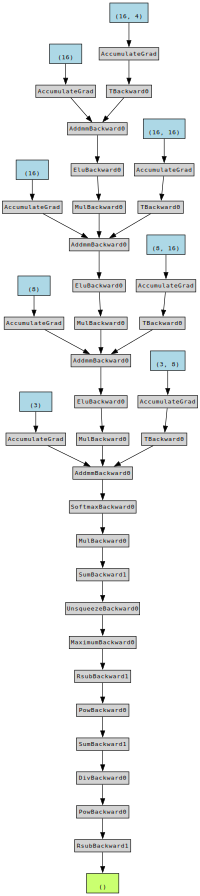

In [15]:
batch = next(iter(test_loader))

var_mapping = {}

kb.partition_data(var_mapping,batch, loader )

kb.rules[0].comp_graph(var_mapping)